How does Area, Major Axis Length, Convex Area, and Perimeter identify the Class of a Given Raisin?

**Intro**

Raisins are a common snack distributed globally which contain high concentrations of carbohydrates, and beneficial nutrients
such as Iron, Potassium, fiber, and antioxidants. Cinar et al., (2020) conducted an analysis of two common classes of raisins 
produced using grapes grown in Turkey with the intention of developing a machine vision system which could use multiple predictors 
to differentiate between Besni and Keciman raisin varieties. The study used a morphological interface consisting of seven different
features to collect data on the varieties. The program uses imaging, which takes measurements of each raisin based on the number of
pixels it takes up. We will be using this previously collected data from Cinar et al., (2020) to predict the class of an observed 
raisin based on predictors including the raisins area, major axis lengths, convex area, and perimeter.

First, we load any neccesary libraries.

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In the following cell, we read the dataset from web into R.

In [2]:
url <- "https://raw.githubusercontent.com/dvolman/DSCI-Group-Project/main/Raisin_Dataset.csv"
raisin_data <- read_csv(url)
raisin_data

Rows: 900 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Class
dbl (7): Area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, E...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
87524,442.2460,253.2912,0.8197384,90546,0.7586506,1184.040,Kecimen
75166,406.6907,243.0324,0.8018052,78789,0.6841296,1121.786,Kecimen
90856,442.2670,266.3283,0.7983536,93717,0.6376128,1208.575,Kecimen
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
99657,431.7070,298.8373,0.7216841,106264,0.7410985,1292.828,Besni
93523,476.3441,254.1761,0.8457385,97653,0.6587983,1258.548,Besni
85609,512.0818,215.2720,0.9073454,89197,0.6320200,1272.862,Besni


**Tidy Data**

A data frame can be considered tidy when it meets the following requirements:

- each row is a single observation,
- each column is a single variable, and
- each value is a single cell (i.e., its entry in the data frame is not shared with another value).
  
Given that `raisin_data` already meets these conditions, additional steps to tidy the data are not required. 

Since we are treating `Class` as a categorical variable, we convert it into a factor. We also rename the columns for readability.

In [3]:
raisin_data <- raisin_data |>
                mutate(Class = as_factor(Class))
colnames(raisin_data) <- c("Area", "Major_Axis_Length", "Minor_Axis_Length", "Eccentricity", "Convex_Area", "Extent", "Perimeter", "Class")
raisin_data

Area,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Perimeter,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
87524,442.2460,253.2912,0.8197384,90546,0.7586506,1184.040,Kecimen
75166,406.6907,243.0324,0.8018052,78789,0.6841296,1121.786,Kecimen
90856,442.2670,266.3283,0.7983536,93717,0.6376128,1208.575,Kecimen
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
99657,431.7070,298.8373,0.7216841,106264,0.7410985,1292.828,Besni
93523,476.3441,254.1761,0.8457385,97653,0.6587983,1258.548,Besni
85609,512.0818,215.2720,0.9073454,89197,0.6320200,1272.862,Besni


**Method**

We will conduct a data analysis using the K-Nearest algorithm to perform a binary classification. We will split our dataset into a training set, validation set, and testing set using the `initial_split()` function from the tidymodels package. We will use columns including `Area` (the number of pixels within the raisins boundary), `Major_Axis_Length` (the length of the main axis, which is the longest line that can be drawn on the raisin grain), `Convex_Area` (the number of pixels within the smallest convex shell of the raisin), and `Perimeter` (measures the environment by calculating the distance between the boundaries of the raisin grain and the pixels around it) as our predictors, due to their high values of standard deviation. Due to the large range of values in each column, an important step will be to standardize the data to give each value  the same weight. Results will be visualized using histograms in order to observe the relationships between various predictors and raisin class. These visualizations will also be helpful to understand distances between observations during the classification process. 

In [4]:
set.seed(5)

raisin_split <- initial_split(raisin_data, prop = 0.75, strata = Class)
raisin_train <- training(raisin_split)
raisin_test <- testing(raisin_split)
raisin_train
raisin_test

Area,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Perimeter,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
137583,649.5415,273.2603,0.9072011,142650,0.7316377,1590.354,Besni
117592,533.2929,288.5583,0.8409660,123587,0.7300677,1432.006,Besni
95546,487.1783,251.9602,0.8558749,99166,0.7227820,1276.807,Besni
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
67874,360.0235,243.2720,0.7371662,69889,0.6783194,1035.277,Kecimen
50312,354.2356,182.3121,0.8573923,52070,0.6233522,961.439,Kecimen
41995,259.2089,210.3508,0.5843375,43443,0.7297006,801.526,Kecimen


Area,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Perimeter,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
87524,442.2460,253.2912,0.8197384,90546,0.7586506,1184.040,Kecimen
75166,406.6907,243.0324,0.8018052,78789,0.6841296,1121.786,Kecimen
79408,352.1908,290.8275,0.5640113,81463,0.7927719,1073.251,Kecimen
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
94282,494.1630,244.8039,0.8686701,97707,0.7023862,1269.680,Besni
68799,356.5678,253.2547,0.7039427,71879,0.7009292,1041.270,Besni
93523,476.3441,254.1761,0.8457385,97653,0.6587983,1258.548,Besni


In the following cell, we summarize number of observations for each class as a percentage of total observations. We also confirm there are no missing data. 

In [5]:
missing_data <- any(is.na(raisin_train))
total_obs <- nrow(raisin_data) 
summary <- raisin_data |>
            group_by(Class) |>
            summarize(count = n(), percentage = n() / total_obs * 100, missing_data = missing_data)
summary

Class,count,percentage,missing_data
<fct>,<int>,<dbl>,<lgl>
Kecimen,450,50,FALSE
Besni,450,50,FALSE


The following table will summarize the mean values of the predictors we will be using. 

In [6]:
mean_predictors <- raisin_data |>
                summarize(mean_Area = mean(Area),
                         mean_Major_Axis_Length = mean(Major_Axis_Length),
                         mean_Convex_Area = mean(Convex_Area),
                         mean_Perimeter = mean(Perimeter))
mean_predictors

mean_Area,mean_Major_Axis_Length,mean_Convex_Area,mean_Perimeter
<dbl>,<dbl>,<dbl>,<dbl>
87804.13,430.93,91186.09,1165.907


The following visualizations show the distribution of each class in each predictor we will be using.

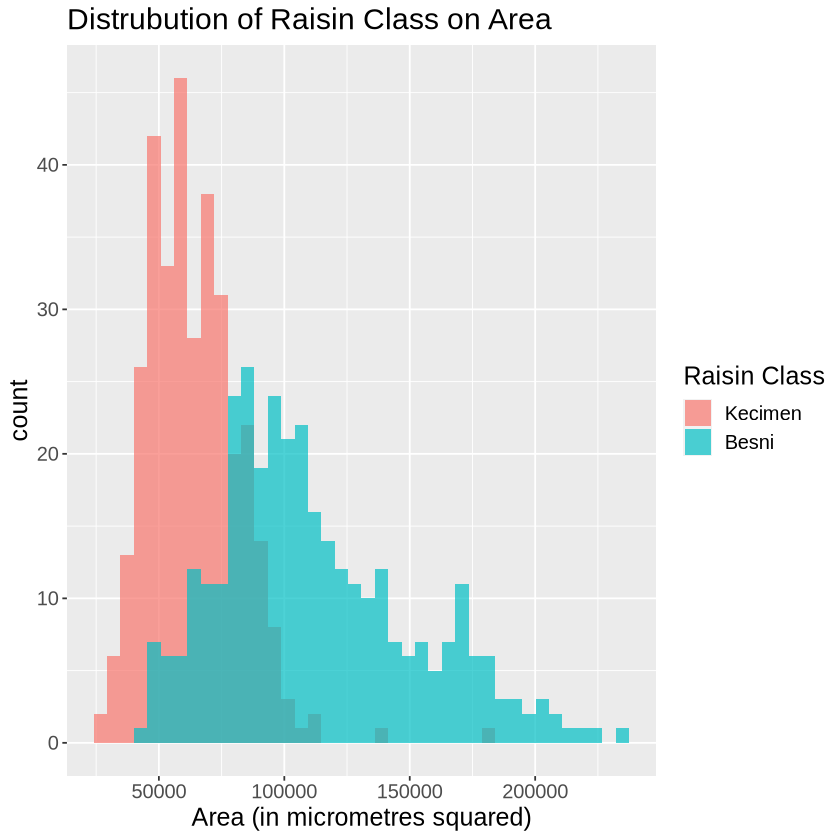

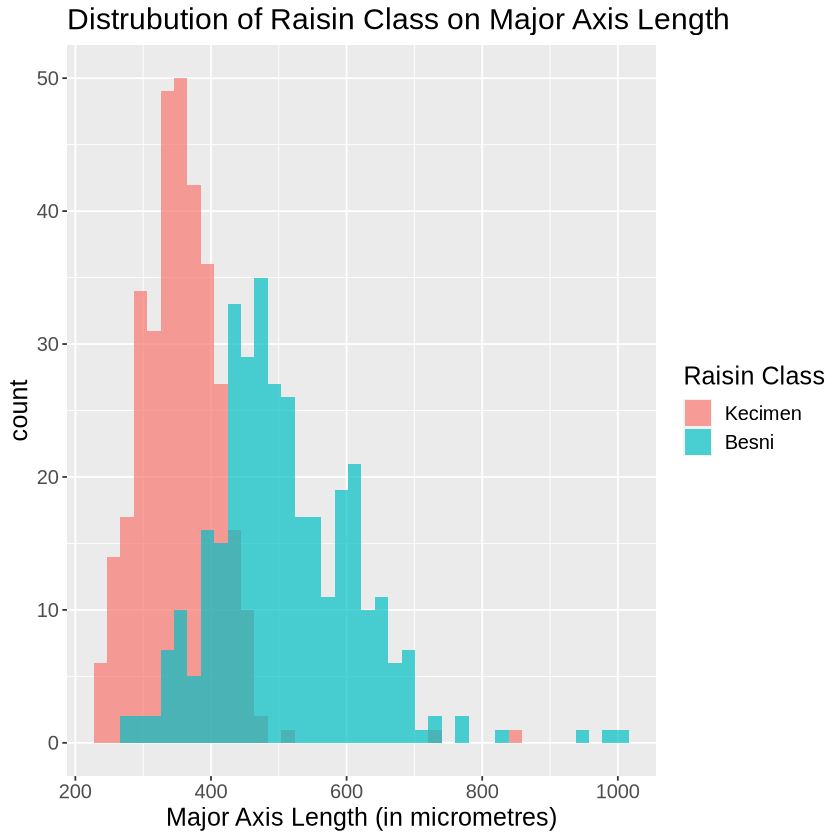

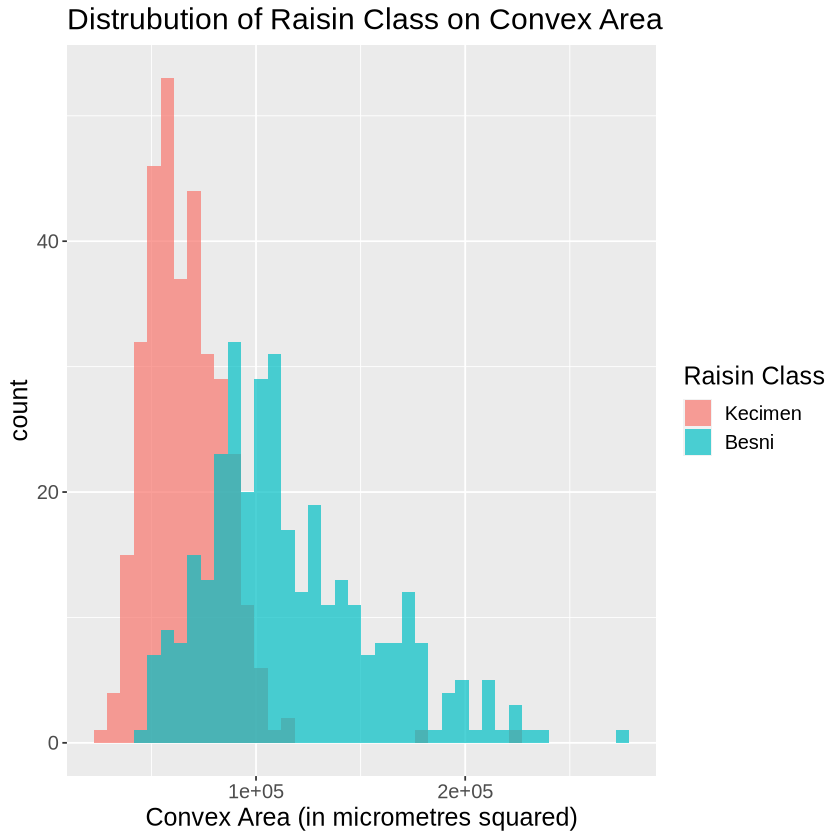

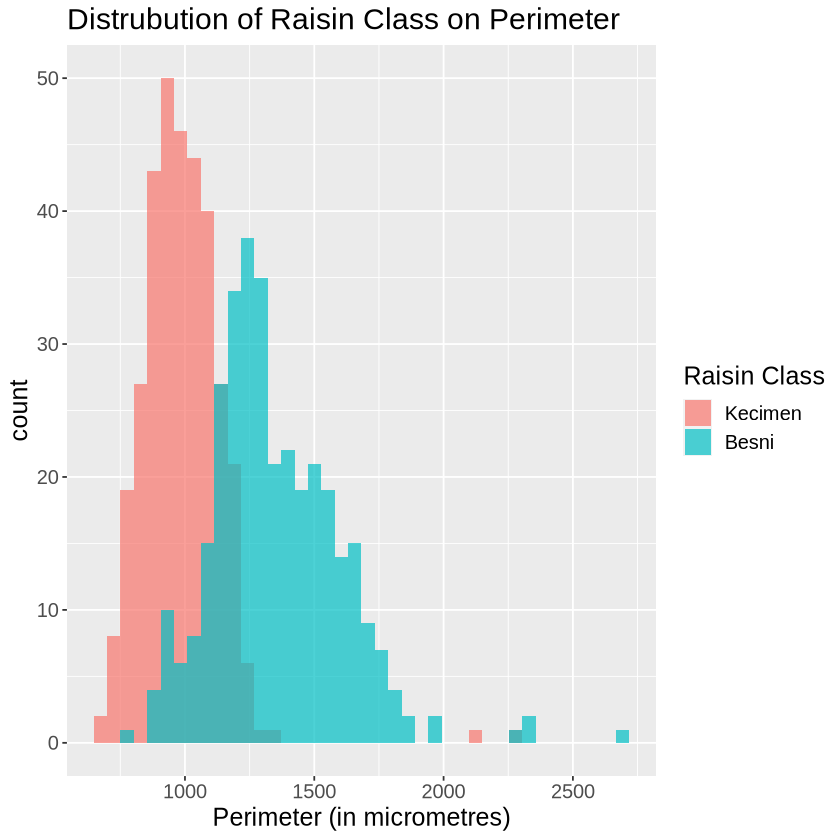

In [7]:
hist_Area <- raisin_train |>
                    ggplot(aes(x = Area, fill = Class)) +
                    geom_histogram(position = "identity", alpha = 0.7, bins = 40) +
                    labs(x = "Area (in micrometres squared)", fill = "Raisin Class", 
                         title = "Distrubution of Raisin Class on Area") +
                    theme(text = element_text(size = 15))
hist_Major_Axis_Length <- raisin_train |>
                    ggplot(aes(x = Major_Axis_Length, fill = Class)) +
                    geom_histogram(position = "identity", alpha = 0.7, bins = 40) +
                    labs(x = "Major Axis Length (in micrometres)", fill = "Raisin Class", 
                         title = "Distrubution of Raisin Class on Major Axis Length") +
                    theme(text = element_text(size = 15))
hist_Convex_Area <- raisin_train |>
                    ggplot(aes(x = Convex_Area, fill = Class)) +
                    geom_histogram(position = "identity", alpha = 0.7, bins = 40) +
                    labs(x = "Convex Area (in micrometres squared)", fill = "Raisin Class", 
                         title = "Distrubution of Raisin Class on Convex Area") +
                    theme(text = element_text(size = 15))
hist_Perimeter <- raisin_train |>
                    ggplot(aes(x = Perimeter, fill = Class)) +
                    geom_histogram(position = "identity", alpha = 0.7, bins = 40) +
                    labs(x = "Perimeter (in micrometres)", fill = "Raisin Class", 
                         title = "Distrubution of Raisin Class on Perimeter") +
                    theme(text = element_text(size = 15))
hist_Area
hist_Major_Axis_Length
hist_Convex_Area
hist_Perimeter

**Expected outcomes and significance**

We expect to find that the raisins with the largest area, convex area, and major axis lengths will be of the Besni variety. These findings could improve the quality of raisin class evaluation and aid in the development of automated raisin evaluation systems, which can be more accurate and significantly more efficient than evaluating raisins by hand (Cinar et al., 2020). Reducing the time and financial requirements of raisin evaluation would have financial benefits for raisin producers, and economic benefits for countries with large exports of raisin products. These findings also raise questions about other measurable features that may be important in assessing raisin quality, and about how improved class evaluation could be used to maximize the production of raisins with preferable features. 

References
    Çinar, İ̇., Koklu, M., & Tasdemir, S. (2023). Raisin. UCI Machine Learning Repository. https://doi.org/10.24432/C5660T.
    Cinar, I., Koklu, M., & Tasdemir, S. (2020). Kuru Üzüm Tanelerinin Makine Görüşü ve Yapay Zeka Yöntemleri Kullanılarak Sınıflandırılması. Gazi Journal of Engineering Sciences.